In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [4]:
data = pd.read_csv('lenta_sample.csv')

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [8]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MAX_LEN = max(len(x) for x in X)

In [16]:
print(f"Max len: {MAX_LEN}")

Max len: 3578


Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [17]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN, MEAN_LEN

(3578, 170.0)

In [19]:
MAX_LEN = int(MEAN_LEN + 30)

In [20]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
X.shape

(147852, 200)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [23]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

---
# Homework starts here
---

In [43]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs,)


cnn_1 = tf.keras.layers.Conv1D(
    filters=256, kernel_size=5,
    padding='same', activation='swish',
)(embeddings)

pool_1 = tf.keras.layers.AveragePooling1D(
    pool_size=2
)(cnn_1)

cnn_2 = tf.keras.layers.Conv1D(
    filters=128, kernel_size=15,
    padding='same', activation='swish',
)(pool_1)

pool_2 = tf.keras.layers.AveragePooling1D(
    pool_size=4
)(cnn_2)

drop = tf.keras.layers.Dropout(rate=0.2, seed=42)(pool_2)

gru_forward =  tf.keras.layers.GRU(
    128, return_sequences=False
)(drop)
lstm_backward =  tf.keras.layers.LSTM(
    128, return_sequences=False,
    go_backwards=True
)(drop)

hidden = tf.keras.layers.concatenate([gru_forward, lstm_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')]
)

In [44]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 30)      1658820     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 200, 256)     38656       embedding_4[0][0]                
__________________________________________________________________________________________________
average_pooling1d_8 (AveragePoo (None, 100, 256)     0           conv1d_6[0][0]                   
____________________________________________________________________________________________

In [45]:
# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    min_delta=0.01, # какая разница считается как улучшение
    patience=3, # сколько эпох терпеть отсутствие улучшений
    verbose=1, 
    mode='max',
)

In [46]:
model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=2000,
    epochs=20
)

Epoch 1/20
71/71 [==============================] - 37s 475ms/step - loss: 2.0980 - f1: 0.0480 - rec@prec: 0.0202 - val_loss: 1.6659 - val_f1: 0.1646 - val_rec@prec: 0.0855
Epoch 2/20
71/71 [==============================] - 33s 460ms/step - loss: 1.3127 - f1: 0.4496 - rec@prec: 0.3420 - val_loss: 1.0054 - val_f1: 0.6881 - val_rec@prec: 0.6064
Epoch 3/20
71/71 [==============================] - 33s 463ms/step - loss: 0.7788 - f1: 0.7643 - rec@prec: 0.7446 - val_loss: 0.8597 - val_f1: 0.7393 - val_rec@prec: 0.6925
Epoch 4/20
71/71 [==============================] - 33s 466ms/step - loss: 0.5733 - f1: 0.8281 - rec@prec: 0.8491 - val_loss: 0.8576 - val_f1: 0.7490 - val_rec@prec: 0.7065
Epoch 5/20
71/71 [==============================] - 33s 469ms/step - loss: 0.4359 - f1: 0.8700 - rec@prec: 0.9102 - val_loss: 0.9041 - val_f1: 0.7462 - val_rec@prec: 0.6996
Epoch 6/20
71/71 [==============================] - 33s 468ms/step - loss: 0.3295 - f1: 0.9035 - rec@prec: 0.9492 - val_loss: 0.9602 - 

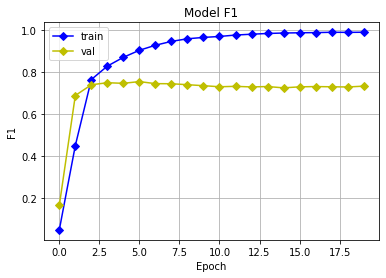

In [47]:
plt.plot(model.history.history['f1'], "b-D")
plt.plot(model.history.history['val_f1'], "y-D")
plt.grid()
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()